# Relevance Forward Propagation (RFP) for Multi-Source MNIST

In [1]:
from datasets.multisource_mnist import MSMNIST;
from models.networks.small_net import SmallNet;
from models.network_mapper import to_relevance_representation, to_basic_representation;
from utils.Utils import input_mapping, set_seed
import matplotlib.pyplot as plt;
from matplotlib.gridspec import GridSpec
from torch.utils.data import DataLoader;
import seaborn as sns

import torch;

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)

Device: cuda


## Experiment Setup
| Variable | Options | Explanation |
| --- | --- | --- |
| label_summation | True or False | Shuffle images and sum up labels modulo ten |
| split_image | True or False | Split image vertically or give full image to both data sources |
| frac_data_noise1 | Any float value between zero and one | Fraction of noisy examples in Data Source 1 |
| frac_data_noies2 | Any float value between zero and one | Fraction of noisy examples in Data Source 2 |
| frac_label_noise1 | Any float value between zero and one | Fraction of random labels in Data Source 1 |
| frac_label_noies2 | Any float value between zero and one | Fraction of random labels in Data Source 2 |
| shuffle1 |  True or False | Shuffle pixels of Data Source 1 |
| shuffle2 | True or False | Shuffle pixels of Data Source 2 |

In [69]:
# Data Setup
label_summation = False
split_image = True
frac_data_noise1 = 0
frac_data_noise2 = 0
frac_label_noise1 = 0
frac_label_noise2 = 0

shuffle1 = False
shuffle2 = False

/home/jakob/Documents/PhD/Projects/ModalityRelevanceScores/venv/lib/python3.9/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


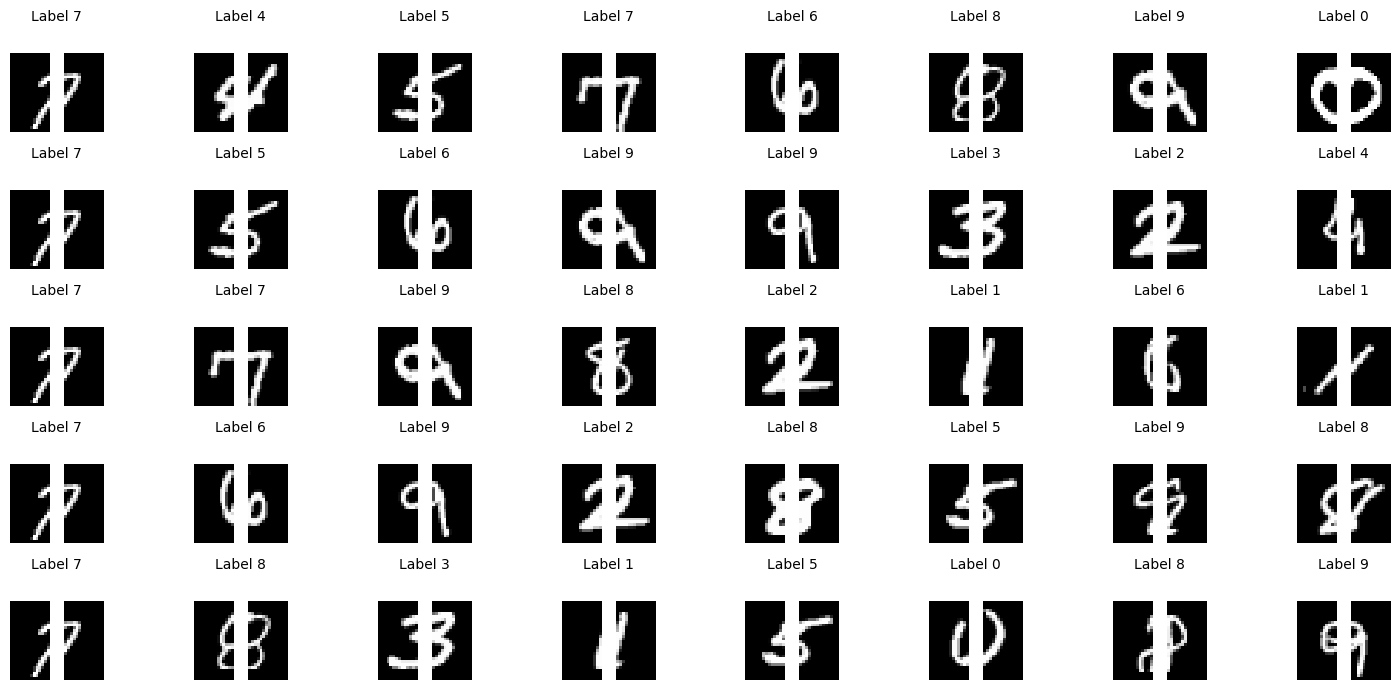

In [ ]:
set_seed(42)
train_data = MSMNIST(train=True, 
                     label_summation=label_summation, 
                     split_image=split_image, 
                     frac_data_noise1=frac_data_noise1,
                     frac_data_noise2=frac_data_noise2,
                     frac_label_noise1=frac_label_noise1,
                     frac_label_noise2=frac_label_noise2,
                     shuffle1=shuffle1,
                     shuffle2=shuffle2);

# Example Visualization
| Variable | Options | Explanation |
| --- | --- | --- |
| num_examples | [num_rows, num_cols] | Number of rows and columns of example images |

In [ ]:
# Visualization
num_examples = [5,8]
figsize = [15,7]
fontsize = 10

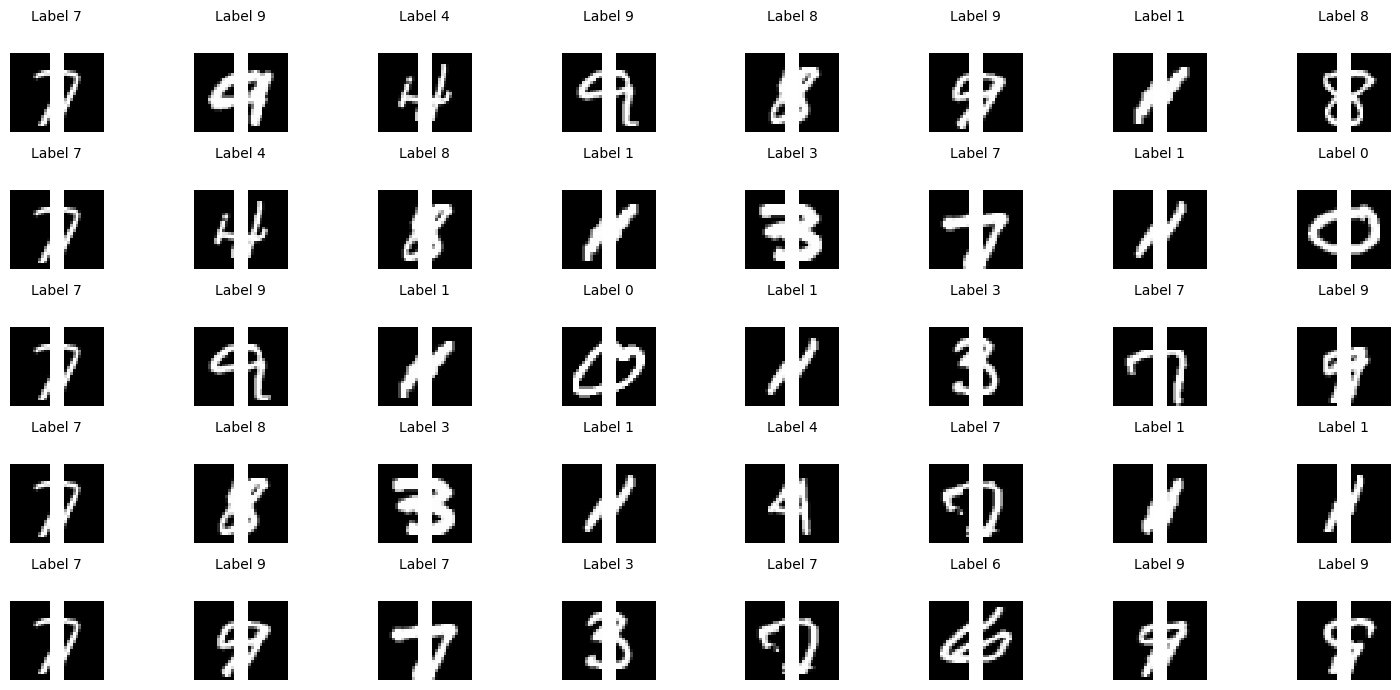

In [71]:
set_seed(42)
fig, axs = plt.subplots(*num_examples, figsize=figsize)
train_data.plot_imgs(axs, num_examples, fontsize=fontsize)
fig.tight_layout()

# Model Training
| Variable | Options | Explanation |
| --- | --- | --- |
| num_epochs | Any int greater zero | Number of epochs to train |
| batch_size | Any int greater zero | Batch size for training and evaluation |
| model_path | any path to (non-) existing file (Default: None)| path to save model to and load from. None for no saving or loading|

In [68]:
# Training Setup
num_epochs = 10
batch_size = 64
model_path = None

In [72]:
set_seed(42)
model = SmallNet(num_classes=10, input_shape=[28,14] if split_image else [28,28]).to(device)
optimizer = torch.optim.SGD(params=model.parameters(), lr=0.1)
criterion = torch.nn.CrossEntropyLoss().to(device)
train_data_loader = DataLoader(train_data, batch_size=batch_size)

for epoch in range(num_epochs):
  correct_count = 0
  total_count = 0
  loss_sum = 0
  for i, data in enumerate(train_data_loader):
    print(f"Epoch [{epoch+1} / {num_epochs}]  -  Iter [{i+1} / {len(train_data_loader)}]    ", end="\r")

    optimizer.zero_grad()
    label = data["label"].to(device)
    x1 = data["img1"].to(device)
    x2 = data["img2"].to(device)
    pred = model(x1,x2)
    loss = criterion(pred, label)

    loss.backward()
    optimizer.step()
    
    loss_sum += loss.detach().cpu().item()
    correct_count += (label == pred.argmax(-1)).sum().cpu().item()
    total_count += len(x1)
  
  print(f"Epoch [{epoch+1} / {num_epochs}]  -  Iter [{i+1} / {len(train_data_loader)}]  -  Loss {loss_sum/len(train_data_loader):.4f}  -  Acc {correct_count/total_count:.4f}")

if model_path is not None:
  print("Save trained model: ", model_path)
  torch.save(model, model_path)

Epoch [1 / 10]  -  Iter [938 / 938]  -  Loss 0.2553  -  Acc 0.9202
Epoch [2 / 10]  -  Iter [938 / 938]  -  Loss 0.0611  -  Acc 0.9813
Epoch [3 / 10]  -  Iter [938 / 938]  -  Loss 0.0387  -  Acc 0.9880
Epoch [4 / 10]  -  Iter [938 / 938]  -  Loss 0.0269  -  Acc 0.9924
Epoch [5 / 10]  -  Iter [938 / 938]  -  Loss 0.0187  -  Acc 0.9950
Epoch [6 / 10]  -  Iter [938 / 938]  -  Loss 0.0135  -  Acc 0.9966
Epoch [7 / 10]  -  Iter [938 / 938]  -  Loss 0.0095  -  Acc 0.9979
Epoch [8 / 10]  -  Iter [938 / 938]  -  Loss 0.0069  -  Acc 0.9984
Epoch [9 / 10]  -  Iter [938 / 938]  -  Loss 0.0044  -  Acc 0.9992
Epoch [10 / 10]  -  Iter [938 / 938]  -  Loss 0.0031  -  Acc 0.9995


## Model Evaluation
#### Load Test Data
**Data Setup**
| Variable | Options | Explanation |
| --- | --- | --- |
| frac_data_noise1 | Any float value between zero and one | Fraction of noisy examples in Data Source 1 (usually 0 or 1 for testing)|
| frac_data_noies2 | Any float value between zero and one | Fraction of noisy examples in Data Source 2 (usually 0 or 1 for testing) |
| frac_label_noise1 | Any float value between zero and one | Fraction of random labels in Data Source 1 (usually 0 or 1 for testing) |
| frac_label_noies2 | Any float value between zero and one | Fraction of random labels in Data Source 2 (usually 0 or 1 for testing) |
| shuffle1 |  True or False | Shuffle pixels of Data Source 1 (usually equivalent to training for testing)|
| shuffle2 | True or False | Shuffle pixels of Data Source 2 (usually equivalent to training for testing)|

In [11]:
# Data Setup
frac_data_noise1_test = 0
frac_data_noise2_test = 0
frac_label_noise1_test = 0
frac_label_noise2_test = 0

shuffle1_test = shuffle1
shuffle2_test = shuffle2

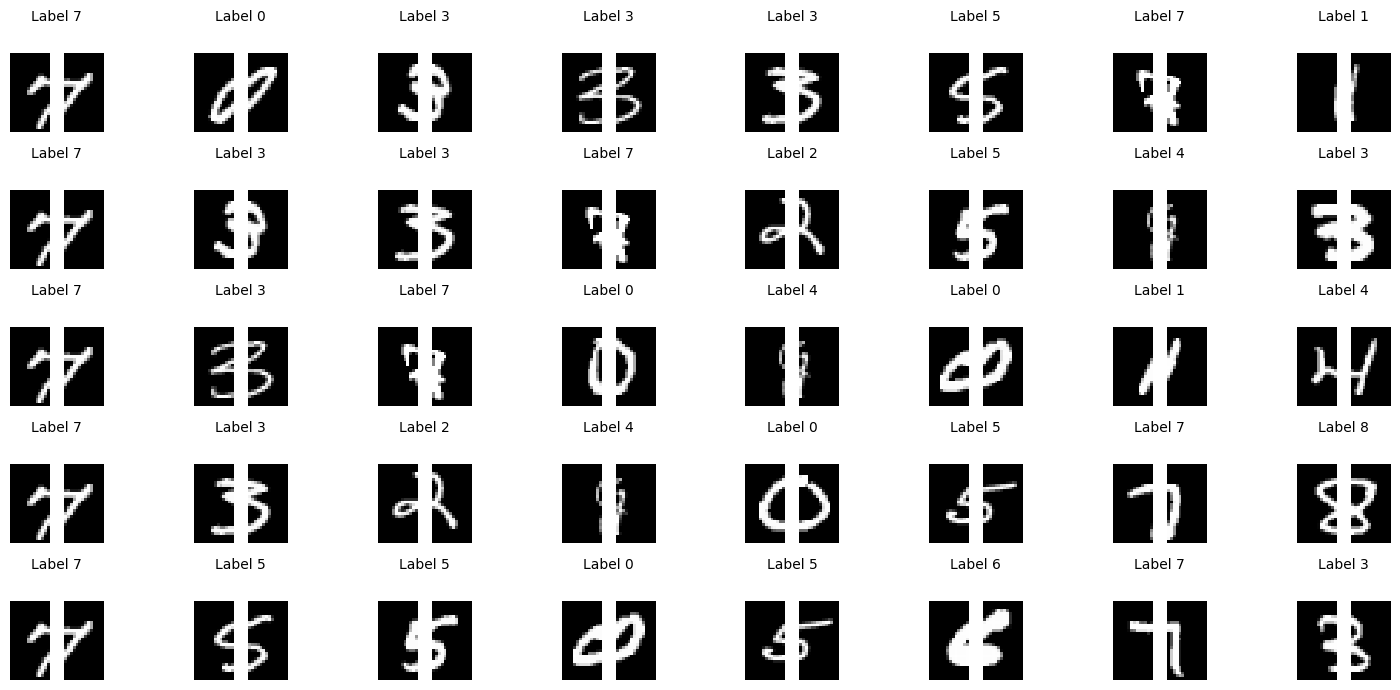

In [12]:
set_seed(42)
test_data = MSMNIST(train=False, 
                     label_summation=label_summation, 
                     split_image=split_image, 
                     frac_data_noise1=frac_data_noise1_test,
                     frac_data_noise2=frac_data_noise2_test,
                     frac_label_noise1=frac_label_noise1_test,
                     frac_label_noise2=frac_label_noise2_test,
                     shuffle1=shuffle1_test,
                     shuffle2=shuffle2_test);

test_data_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

fig, axs = plt.subplots(*num_examples, figsize=figsize)
train_data.plot_imgs(axs, num_examples, fontsize=fontsize)
fig.tight_layout()

In [24]:
print("Evaluate Model")

model.eval()
model = model.double()

with torch.no_grad():
  train_correct_count, test_correct_count = 0, 0
  train_total_count, test_total_count = 0, 0
  train_loss_sum, test_loss_sum = 0, 0
  train_pred_list = []
  test_pred_list = []

  for i, data in enumerate(train_data_loader):
    print(f"Eval Train Performance [{i+1} / {len(train_data_loader)}]    ", end="\r")
    label = data["label"].to(device)
    x1 = data["img1"].double().to(device)
    x2 = data["img2"].double().to(device)
    pred = model(x1,x2)

    train_pred_list.append(pred.cpu())
    train_loss = criterion(pred, label)

    train_loss_sum += train_loss.cpu().item()
    train_correct_count += (label == pred.argmax(-1)).sum().cpu().item()
    train_total_count += len(x1)
  print(f"Eval Train Performance [{i+1} / {len(train_data_loader)}]    " +\
        f"Loss {train_loss_sum/len(train_data_loader):.4f}    "+\
        f"Acc {train_correct_count/train_total_count:.4f}")

  for i, data in enumerate(test_data_loader):
    print(f"Eval Test Performance [{i+1} / {len(test_data_loader)}]    ", end="\r")
    label = data["label"].to(device)
    x1 = data["img1"].double().to(device)
    x2 = data["img2"].double().to(device)
    pred = model(x1,x2)

    test_pred_list.append(pred.cpu())
    test_loss = criterion(pred, label)

    test_loss_sum += test_loss.cpu().item()
    test_correct_count += (label == pred.argmax(-1)).sum().cpu().item()
    test_total_count += x1.shape[-4]

  print(f"Eval Test Performance [{i+1} / {len(test_data_loader)}]     " +\
        f"Loss {test_loss_sum/len(test_data_loader):.4f}    "+\
        f"Acc {test_correct_count/test_total_count:.4f}")
  
  train_pred_list = torch.cat(train_pred_list, 0)
  test_pred_list = torch.cat(test_pred_list, 0)


Evaluate Model
Eval Train Performance [938 / 938]    Loss 0.0064    Acc 0.9979
Eval Test Performance [157 / 157]     Loss 0.0451    Acc 0.9881


#### Relevance Evaluation

In [25]:
print("Evaluate RFP-Model")

model = to_relevance_representation(model=model, verbose=0)
model = model.double().to(device)
model.eval()

with torch.no_grad():
  rfp_train_pred_list = []
  rfp_test_pred_list = []
  rfp_labels = []

  rfp_train_correct_count, rfp_test_correct_count = 0, 0
  rfp_train_total_count, rfp_test_total_count = 0, 0
  rfp_train_loss_sum, rfp_test_loss_sum = 0, 0

  for i, data in enumerate(train_data_loader):
    print(f"Eval Train Performance [{i+1} / {len(train_data_loader)}]    ", end="\r")
    label = data["label"].to(device)

    x1, x2 = input_mapping(data["img1"], data["img2"])

    pred = model(x1.double().to(device),x2.double().to(device))

    rfp_train_pred_list.append(pred.cpu())

    rfp_train_loss_sum += criterion(pred.sum(0), label).cpu().item()
    rfp_train_correct_count += (label == pred.sum(0).argmax(-1)).sum().cpu().item()
    rfp_train_total_count += x1.shape[-4]
    
  print(f"Eval Train Performance [{i+1} / {len(train_data_loader)}]     " +\
        f"Loss {rfp_train_loss_sum/len(train_data_loader):.4f}    "+\
        f"Acc {rfp_train_correct_count/rfp_train_total_count:.4f}")

  for i, data in enumerate(test_data_loader):
    print(f"Eval Test Performance [{i+1} / {len(test_data_loader)}]    ", end="\r")
    label = data["label"].to(device)

    x1, x2 = input_mapping(data["img1"], data["img2"])

    pred = model(x1.double().to(device),x2.double().to(device))

    rfp_test_pred_list.append(pred.cpu())
    rfp_labels.append(label.cpu())

    rfp_test_loss_sum += criterion(pred.sum(0), label).cpu().item()
    rfp_test_correct_count += (label == pred.sum(0).argmax(-1)).sum().cpu().item()
    rfp_test_total_count += x1.shape[-4]
    
  print(f"Eval Test Performance [{i+1} / {len(test_data_loader)}]     " +\
        f"Loss {rfp_test_loss_sum/len(test_data_loader):.4f}    "+\
        f"Acc {rfp_test_correct_count/rfp_test_total_count:.4f}")
  
model = to_basic_representation(model=model, verbose=0)

rfp_labels = torch.cat(rfp_labels, 0)
rfp_train_pred_list = torch.cat(rfp_train_pred_list, -2)
rfp_test_pred_list = torch.cat(rfp_test_pred_list, -2)

Evaluate RFP-Model
Applied monkey patches for contribution propagation.
Eval Train Performance [938 / 938]     Loss 0.0064    Acc 0.9979
Eval Test Performance [157 / 157]     Loss 0.0451    Acc 0.9881
Removed all monkey patches for contribution propagation.


#### Similarity Evaluation

In [26]:
print("Similarity Evaluation RFP and Basic Model")
print()
print("Output shapes")
print(f"    Basic Model:   Train {train_pred_list.shape}   Test {test_pred_list.shape}")
print(f"      RFP Model:   Train {rfp_train_pred_list.shape}   Test {rfp_test_pred_list.shape}")
print(f"Loss:")
print(f"    Basic Model:   Train {train_loss_sum/len(train_data_loader):.6f}     Test {test_loss_sum/len(test_data_loader):.6f}")
print(f"      RFP Model:   Train {rfp_train_loss_sum/len(train_data_loader):.6f}     Test {rfp_test_loss_sum/len(test_data_loader):.6f}")
print(f"          Delta:   Train {(train_loss_sum-rfp_train_loss_sum)/len(train_data_loader):.6f}     Test {(test_loss_sum-rfp_test_loss_sum)/len(test_data_loader):.6f}")
print()
print(f"Accuracy:")
print(f"    Basic Model:   Train {train_correct_count/train_total_count:.6f}     Test {test_correct_count/test_total_count:.6f}")
print(f"      RFP Model:   Train {rfp_train_correct_count/rfp_train_total_count:.6f}     Test {rfp_test_correct_count/rfp_test_total_count:.6f}")
print(f"          Delta:   Train {(train_correct_count-rfp_train_correct_count):.6f}     Test {(test_correct_count-rfp_test_correct_count):.6f}")
print()
print("Model Output")
print(f"    Mean L1-error:   Train {(train_pred_list-rfp_train_pred_list.sum(0)).abs().mean()}     Test {(test_pred_list-rfp_test_pred_list.sum(0)).abs().mean()}")
print(f"     Max L1-error:   Train {(train_pred_list-rfp_train_pred_list.sum(0)).abs().max()}     Test {(test_pred_list-rfp_test_pred_list.sum(0)).abs().max()}")


Similarity Evaluation RFP and Basic Model

Output shapes
    Basic Model:   Train torch.Size([60000, 10])   Test torch.Size([10000, 10])
      RFP Model:   Train torch.Size([3, 60000, 10])   Test torch.Size([3, 10000, 10])
Loss:
    Basic Model:   Train 0.006394     Test 0.045118
      RFP Model:   Train 0.006394     Test 0.045118
          Delta:   Train 0.000000     Test 0.000000

Accuracy:
    Basic Model:   Train 0.997883     Test 0.988100
      RFP Model:   Train 0.997883     Test 0.988100
          Delta:   Train 0.000000     Test 0.000000

Model Output
    Mean L1-error:   Train 2.565395842805962e-15     Test 2.572654045091688e-15
     Max L1-error:   Train 4.263256414560601e-14     Test 3.552713678800501e-14


# Relevance Visualizations
Visualization of sample-wise relevance of data source 1 (L), data source 2 (R) and the sample-wise difference (L-R).

Density over 10000 points!


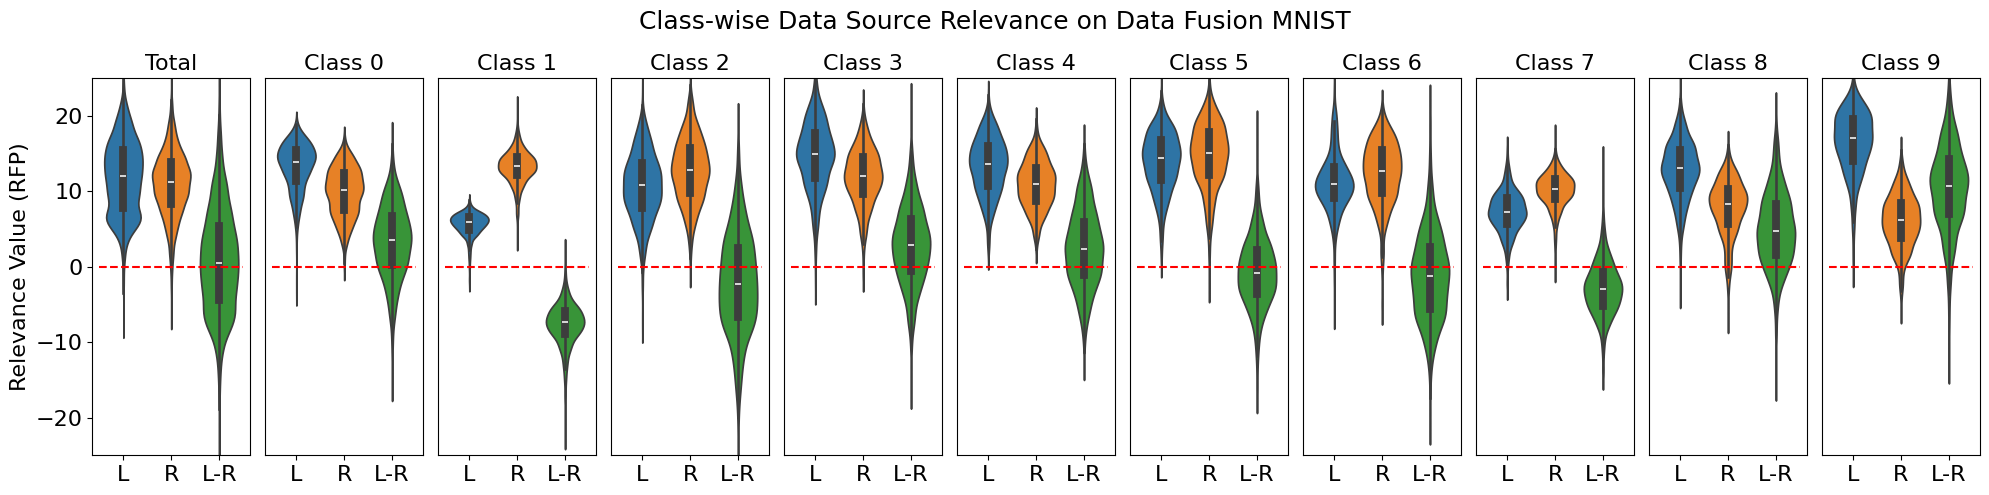

In [64]:
# uses contributions and labels of previous cells

data = {}

num_classes = rfp_test_pred_list.shape[-1]
num_samples = len(rfp_test_pred_list[0])

print(f"Density over {num_samples} points!")
text_size = 16
title_size = 18
fig, axs = plt.subplots(nrows=1, ncols=num_classes+1, figsize=(20,5))

data["Contribution"]  =  []
data["Source"] = []

for i in range(num_classes+1):

  if i > 0:
    ids_filter = [k for k in range(len(rfp_labels)) if rfp_labels[k] == i-1]
    data["Contribution"] = [rfp_test_pred_list[1,id,i-1].item() for id in ids_filter] + \
                            [rfp_test_pred_list[2,id,i-1].item() for id in ids_filter] + \
                            [rfp_test_pred_list[1,id,i-1].item()-rfp_test_pred_list[2,id,i-1].item() for id in ids_filter]
  else:
    ids_filter = range(len(rfp_labels))
    data["Contribution"] = [rfp_test_pred_list[1,id,rfp_labels[id]].item() for id in ids_filter] + \
                            [rfp_test_pred_list[2,id,rfp_labels[id]].item() for id in ids_filter] + \
                            [rfp_test_pred_list[1,id,rfp_labels[id]].item()-rfp_test_pred_list[2,id,rfp_labels[id]].item() for id in ids_filter]


  data["Source"] = ["L"] * len(ids_filter) + ["R"] * len(ids_filter) + ["L-R"] * len(ids_filter)

  sns.violinplot(data=data,
                  x="Source",
                  y="Contribution",
                  hue="Source",
                  split=False, 
                  ax=axs[i],
                  orient="v",
                  saturation=0.8
                  )
  
  if i==0:
    axs[i].set_ylabel('Relevance Value (RFP)', fontsize=text_size)
    axs[i].tick_params(axis='x', labelsize=text_size)
    axs[i].tick_params(axis='y', labelsize=text_size)

    axs[i].tick_params(axis='x', labelsize=text_size)
    axs[i].tick_params(axis='y', labelsize=text_size)
  else:
    axs[i].tick_params(axis='x', labelsize=text_size)
    axs[i].tick_params(axis='y', labelsize=text_size)
    axs[i].get_yaxis().set_visible(False)

  axs[i].set_ylim([-25,25])
  axs[i].hlines(0, -0.5, 2.5, linestyle="--", color="red")

  if i == 0:
    axs[i].set_title(f"Total", fontsize=text_size)  
  else:
    axs[i].set_title(f"Class {i-1}", fontsize=text_size)
  
  axs[i].set_xlabel('')

fig.suptitle(f"Class-wise Data Source Relevance on Data Fusion MNIST", fontsize=title_size)
fig.tight_layout()

## Example Visualization

| Plot Number | Number of Columns | Number of Rows | Content |
| --- | ---| --- | --- |
| 1st Plot | ncols | 10 | ncols examples per class 
| 2nd Plot | ncols | nrows | examples of correct predictions
| 3rd Plot | ncols | nrows | examples of false predictions

In [65]:
nrows = 10
ncols = 2

### Class-wise Examples

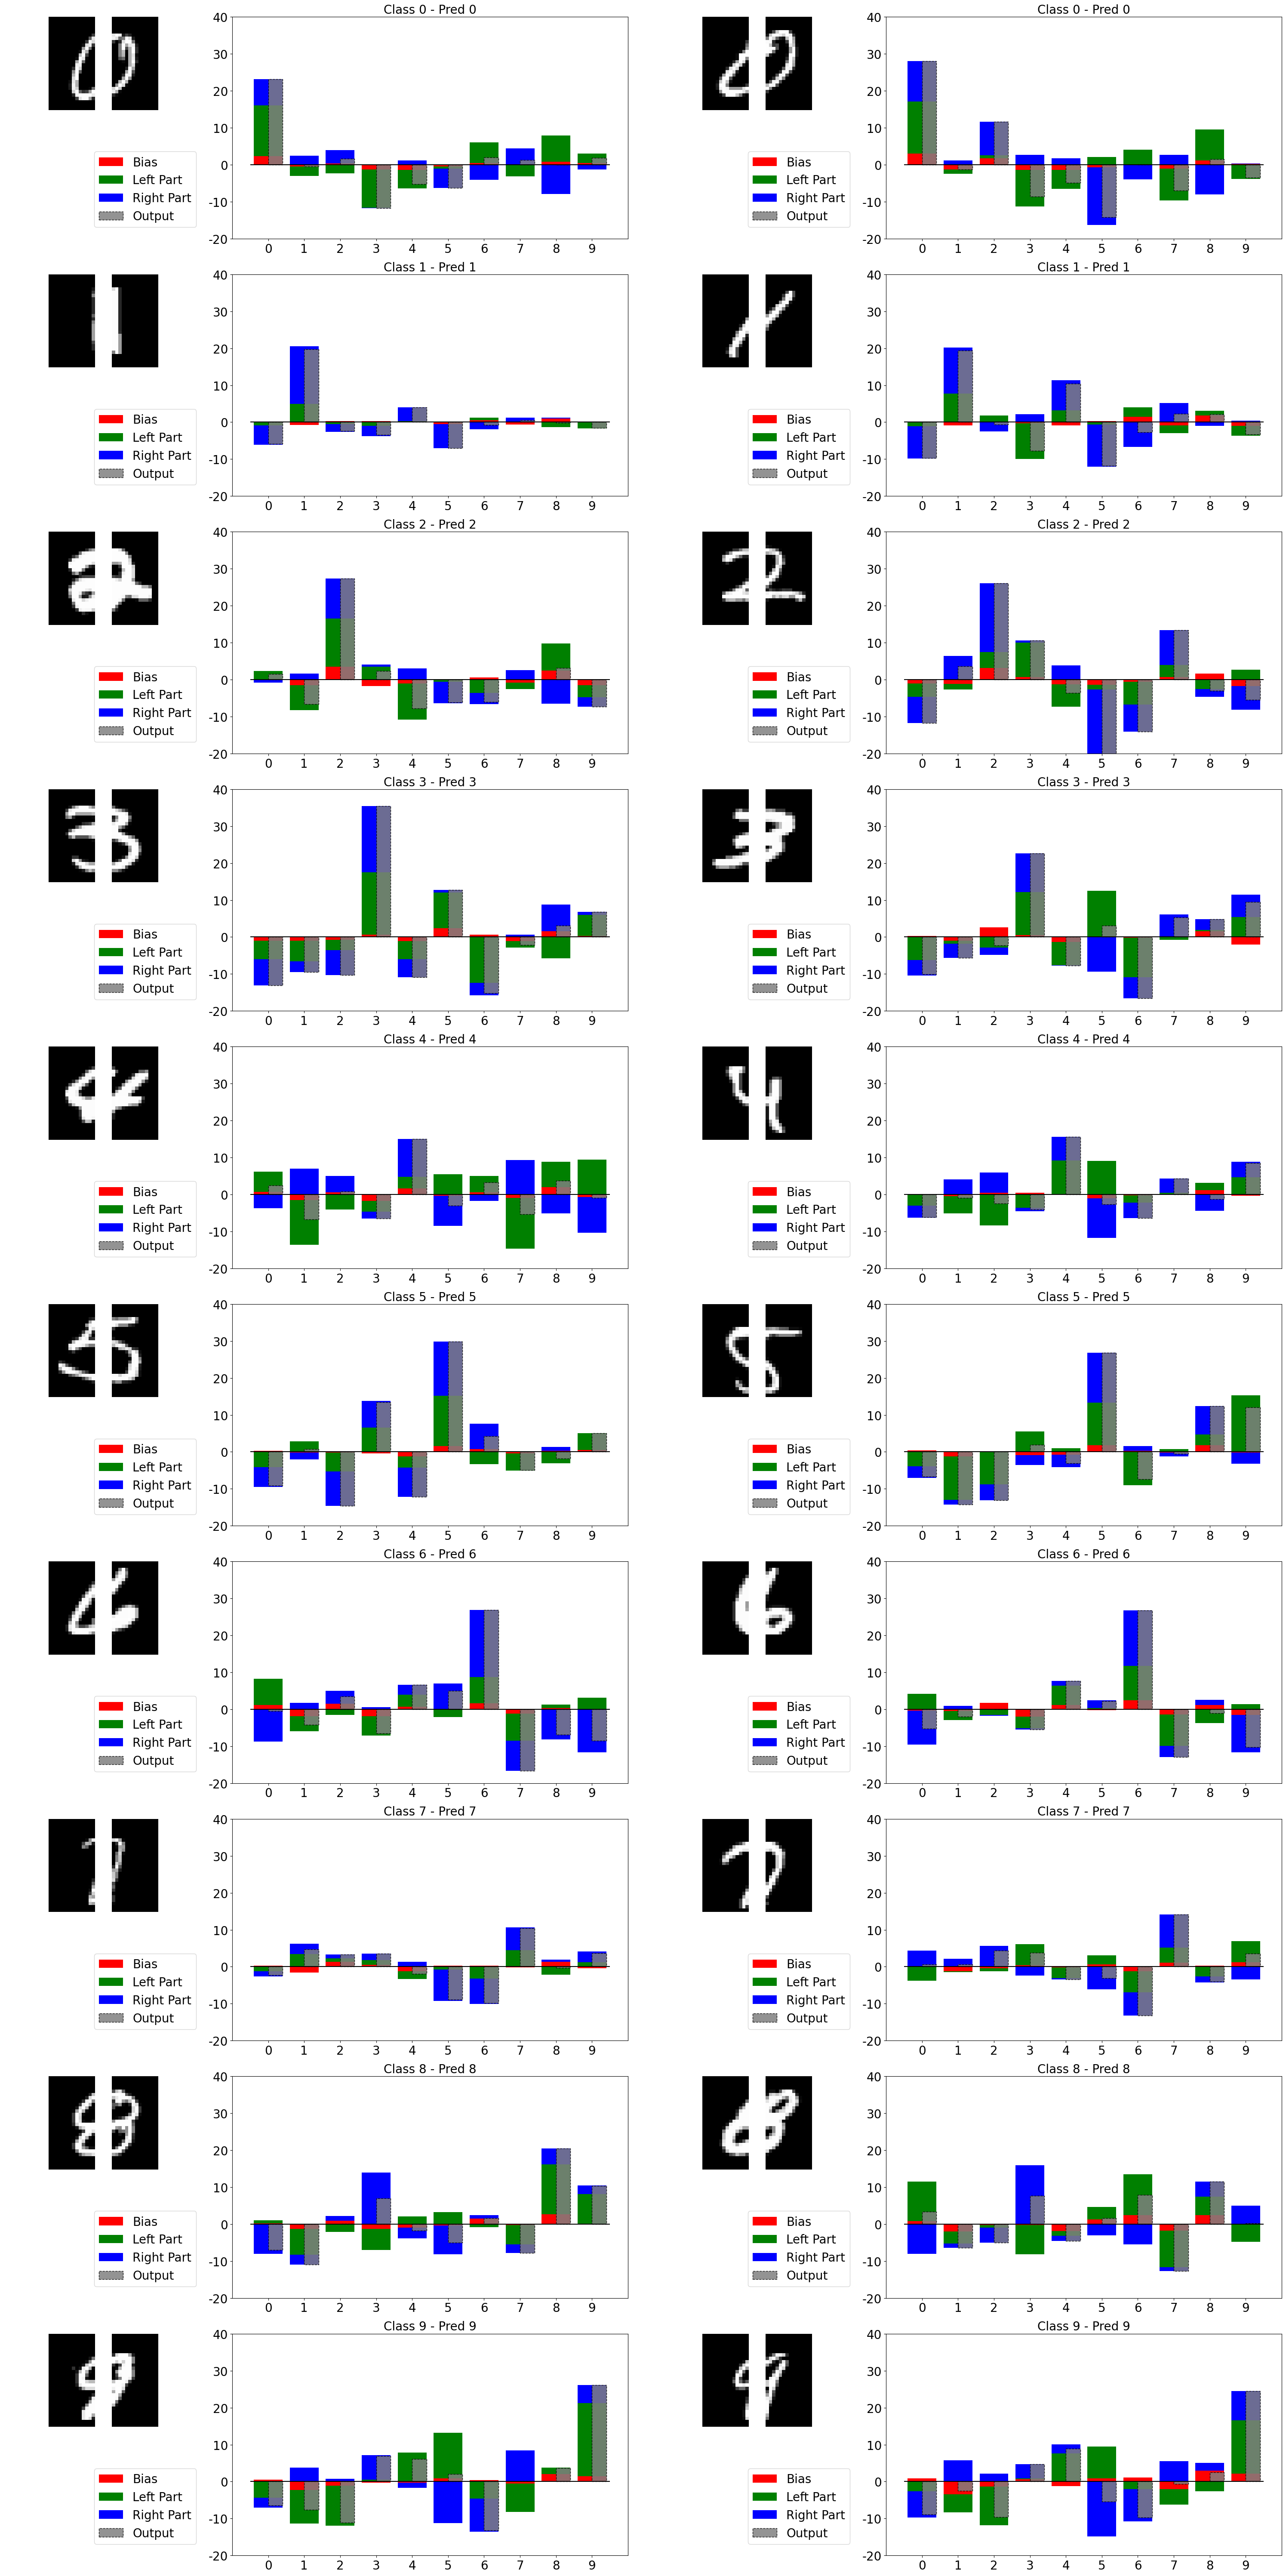

In [66]:
set_seed(42)
fig = plt.figure(figsize=(30,60))
fontsize = 20

gs = GridSpec(2*nrows, 2*ncols, 
              figure=fig, 
              height_ratios=nrows * [0.5,0.5], 
              width_ratios=ncols * [0.5, 1])

labels_str = ["Bias", "Left Part", "Right Part"]
for i in range(10):

  sample_ids = [idx for idx in torch.randperm(len(test_data)) if test_data.orig_labels1[idx] == i]
  
  for j in range(ncols):

    sub_sample_id = sample_ids[j]

    data1 = test_data[sub_sample_id]
    data2 = test_data[sub_sample_id]

    ax_tl = fig.add_subplot(gs[2*i, 2*j])
    ax_tr = fig.add_subplot(gs[2*i+1, 2*j])
    ax_b = fig.add_subplot(gs[2*i:2*i+2, 2*j+1])
    
    ax_tl.axis('off')
    ax_tl.matshow(torch.cat([data1["img1"][0], torch.ones([28,5]), data2["img2"][0]], 1), cmap="gray")

    plt.bar(range(10), rfp_test_pred_list[0,sample_ids[j]], label=labels_str[0], color='r')
    plt.bar(range(10), rfp_test_pred_list[1,sample_ids[j]].clip(min=0), bottom=rfp_test_pred_list[:1,sample_ids[j]].clip(min=0).sum(0), label=labels_str[1], color='g')
    plt.bar(range(10), rfp_test_pred_list[1,sample_ids[j]].clip(max=0), bottom=rfp_test_pred_list[:1,sample_ids[j]].clip(max=0).sum(0), color='g')

    ax_b.bar(range(10), rfp_test_pred_list[2,sample_ids[j]].clip(min=0), bottom=rfp_test_pred_list[:2,sample_ids[j]].clip(min=0).sum(0), label=labels_str[2], color='b')
    ax_b.bar(range(10), rfp_test_pred_list[2,sample_ids[j]].clip(max=0), bottom=rfp_test_pred_list[:2,sample_ids[j]].clip(max=0).sum(0), color='b')
    
    ax_b.bar(torch.arange(10)+0.2, rfp_test_pred_list[:3,sample_ids[j]].sum(0), label="Output", width=0.4, color='gray', alpha=0.85, linestyle="--", edgecolor="black")
    ax_b.hlines(y=0,xmin=-0.5, xmax=9.5, color="black")
    ax_b.set_ylim([-20,40])     
    ax_b.set_xticks(range(10))

    ax_b.set_xticks(range(10), range(10), fontsize=fontsize)
    ax_b.set_yticks(range(-20,41,10), range(-20,41,10), fontsize=fontsize)

    ax_b.set_title(f"Class {data1['label']} - Pred {rfp_test_pred_list[:3,sub_sample_id].sum(0).argmax(-1).item()}", fontsize=fontsize)
    ax_tr.axis('off')
    ax_tr.legend(*ax_b.get_legend_handles_labels(), fontsize=fontsize)

  fig.tight_layout()


### Random Correc Predictions

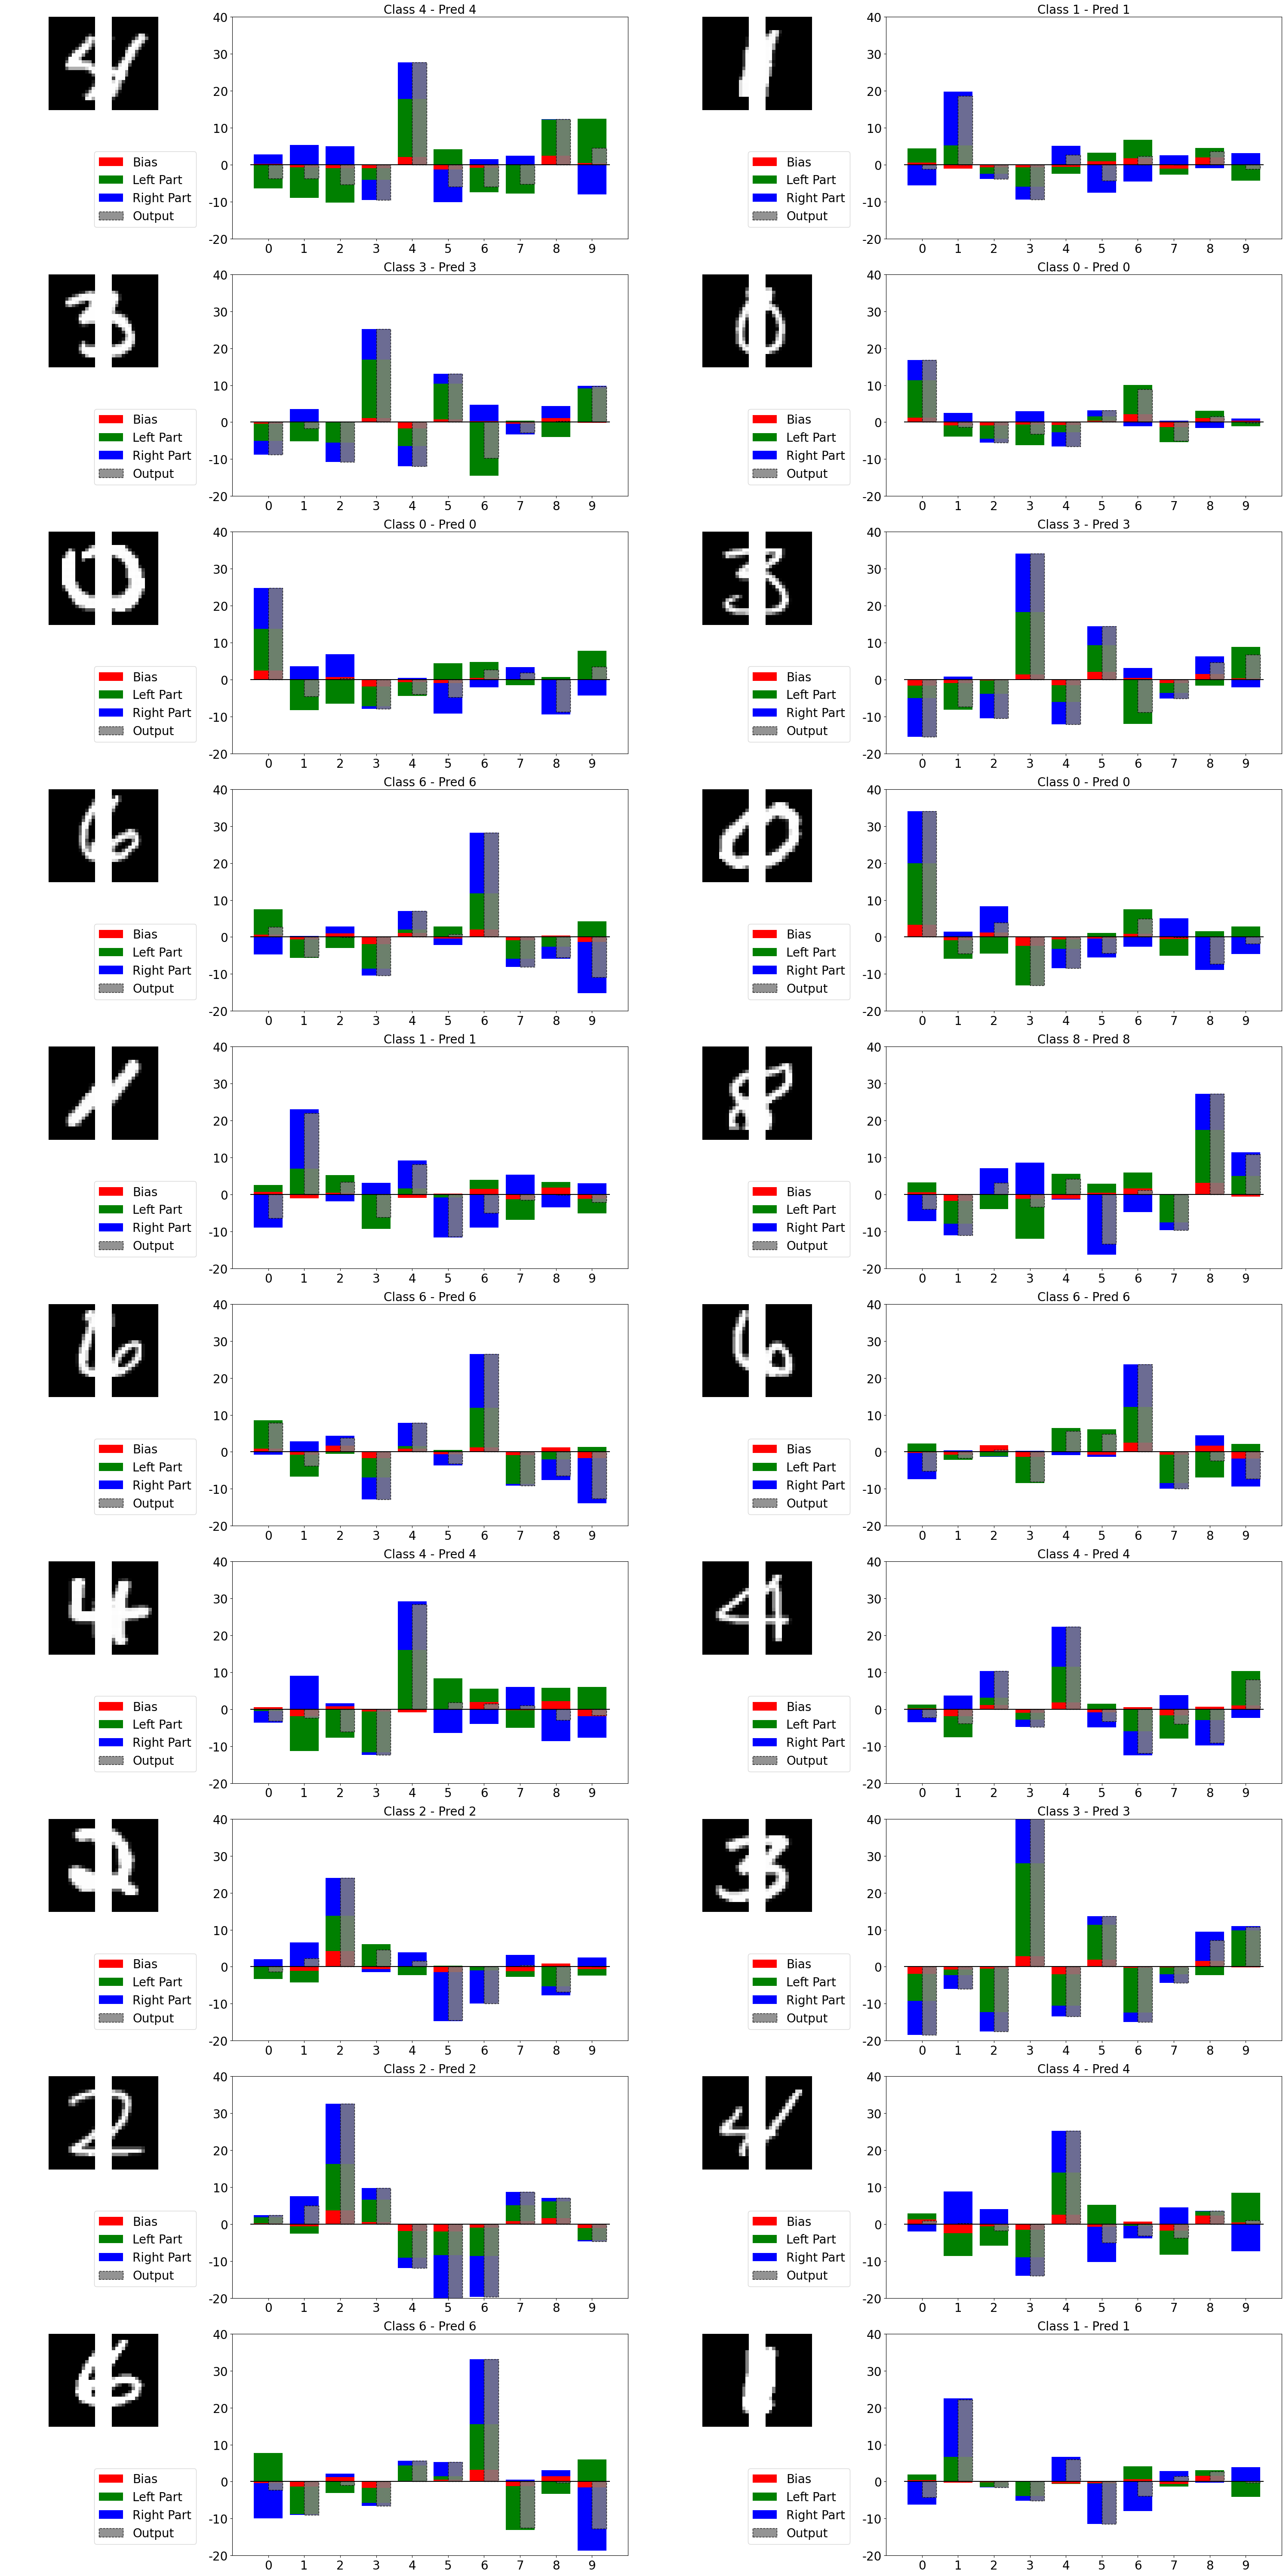

In [67]:
set_seed(42)
fig = plt.figure(figsize=(30,60))
fontsize = 20

gs = GridSpec(2*nrows, 2*ncols, 
              figure=fig, 
              height_ratios=nrows * [0.5,0.5], 
              width_ratios=ncols * [0.5, 1])

labels_str = ["Bias", "Left Part", "Right Part"]
preds = rfp_test_pred_list.sum(0).argmax(-1)
for i in range(nrows):

  sample_ids = [idx for idx in torch.randperm(len(test_data)) if test_data.orig_labels1[idx] == preds[idx]]
  
  for j in range(ncols):

    sub_sample_id = sample_ids[j]

    data1 = test_data[sub_sample_id]
    data2 = test_data[sub_sample_id]

    ax_tl = fig.add_subplot(gs[2*i, 2*j])
    ax_tr = fig.add_subplot(gs[2*i+1, 2*j])
    ax_b = fig.add_subplot(gs[2*i:2*i+2, 2*j+1])
    
    ax_tl.axis('off')
    ax_tl.matshow(torch.cat([data1["img1"][0], torch.ones([28,5]), data2["img2"][0]], 1), cmap="gray")

    plt.bar(range(10), rfp_test_pred_list[0,sample_ids[j]], label=labels_str[0], color='r')
    plt.bar(range(10), rfp_test_pred_list[1,sample_ids[j]].clip(min=0), bottom=rfp_test_pred_list[:1,sample_ids[j]].clip(min=0).sum(0), label=labels_str[1], color='g')
    plt.bar(range(10), rfp_test_pred_list[1,sample_ids[j]].clip(max=0), bottom=rfp_test_pred_list[:1,sample_ids[j]].clip(max=0).sum(0), color='g')

    ax_b.bar(range(10), rfp_test_pred_list[2,sample_ids[j]].clip(min=0), bottom=rfp_test_pred_list[:2,sample_ids[j]].clip(min=0).sum(0), label=labels_str[2], color='b')
    ax_b.bar(range(10), rfp_test_pred_list[2,sample_ids[j]].clip(max=0), bottom=rfp_test_pred_list[:2,sample_ids[j]].clip(max=0).sum(0), color='b')
    
    ax_b.bar(torch.arange(10)+0.2, rfp_test_pred_list[:3,sample_ids[j]].sum(0), label="Output", width=0.4, color='gray', alpha=0.85, linestyle="--", edgecolor="black")
    ax_b.hlines(y=0,xmin=-0.5, xmax=9.5, color="black")
    ax_b.set_ylim([-20,40])     
    ax_b.set_xticks(range(10))

    ax_b.set_xticks(range(10), range(10), fontsize=fontsize)
    ax_b.set_yticks(range(-20,41,10), range(-20,41,10), fontsize=fontsize)

    ax_b.set_title(f"Class {data1['label']} - Pred {rfp_test_pred_list[:3,sub_sample_id].sum(0).argmax(-1).item()}", fontsize=fontsize)
    ax_tr.axis('off')
    ax_tr.legend(*ax_b.get_legend_handles_labels(), fontsize=fontsize)

  fig.tight_layout()


### Random False Predictions

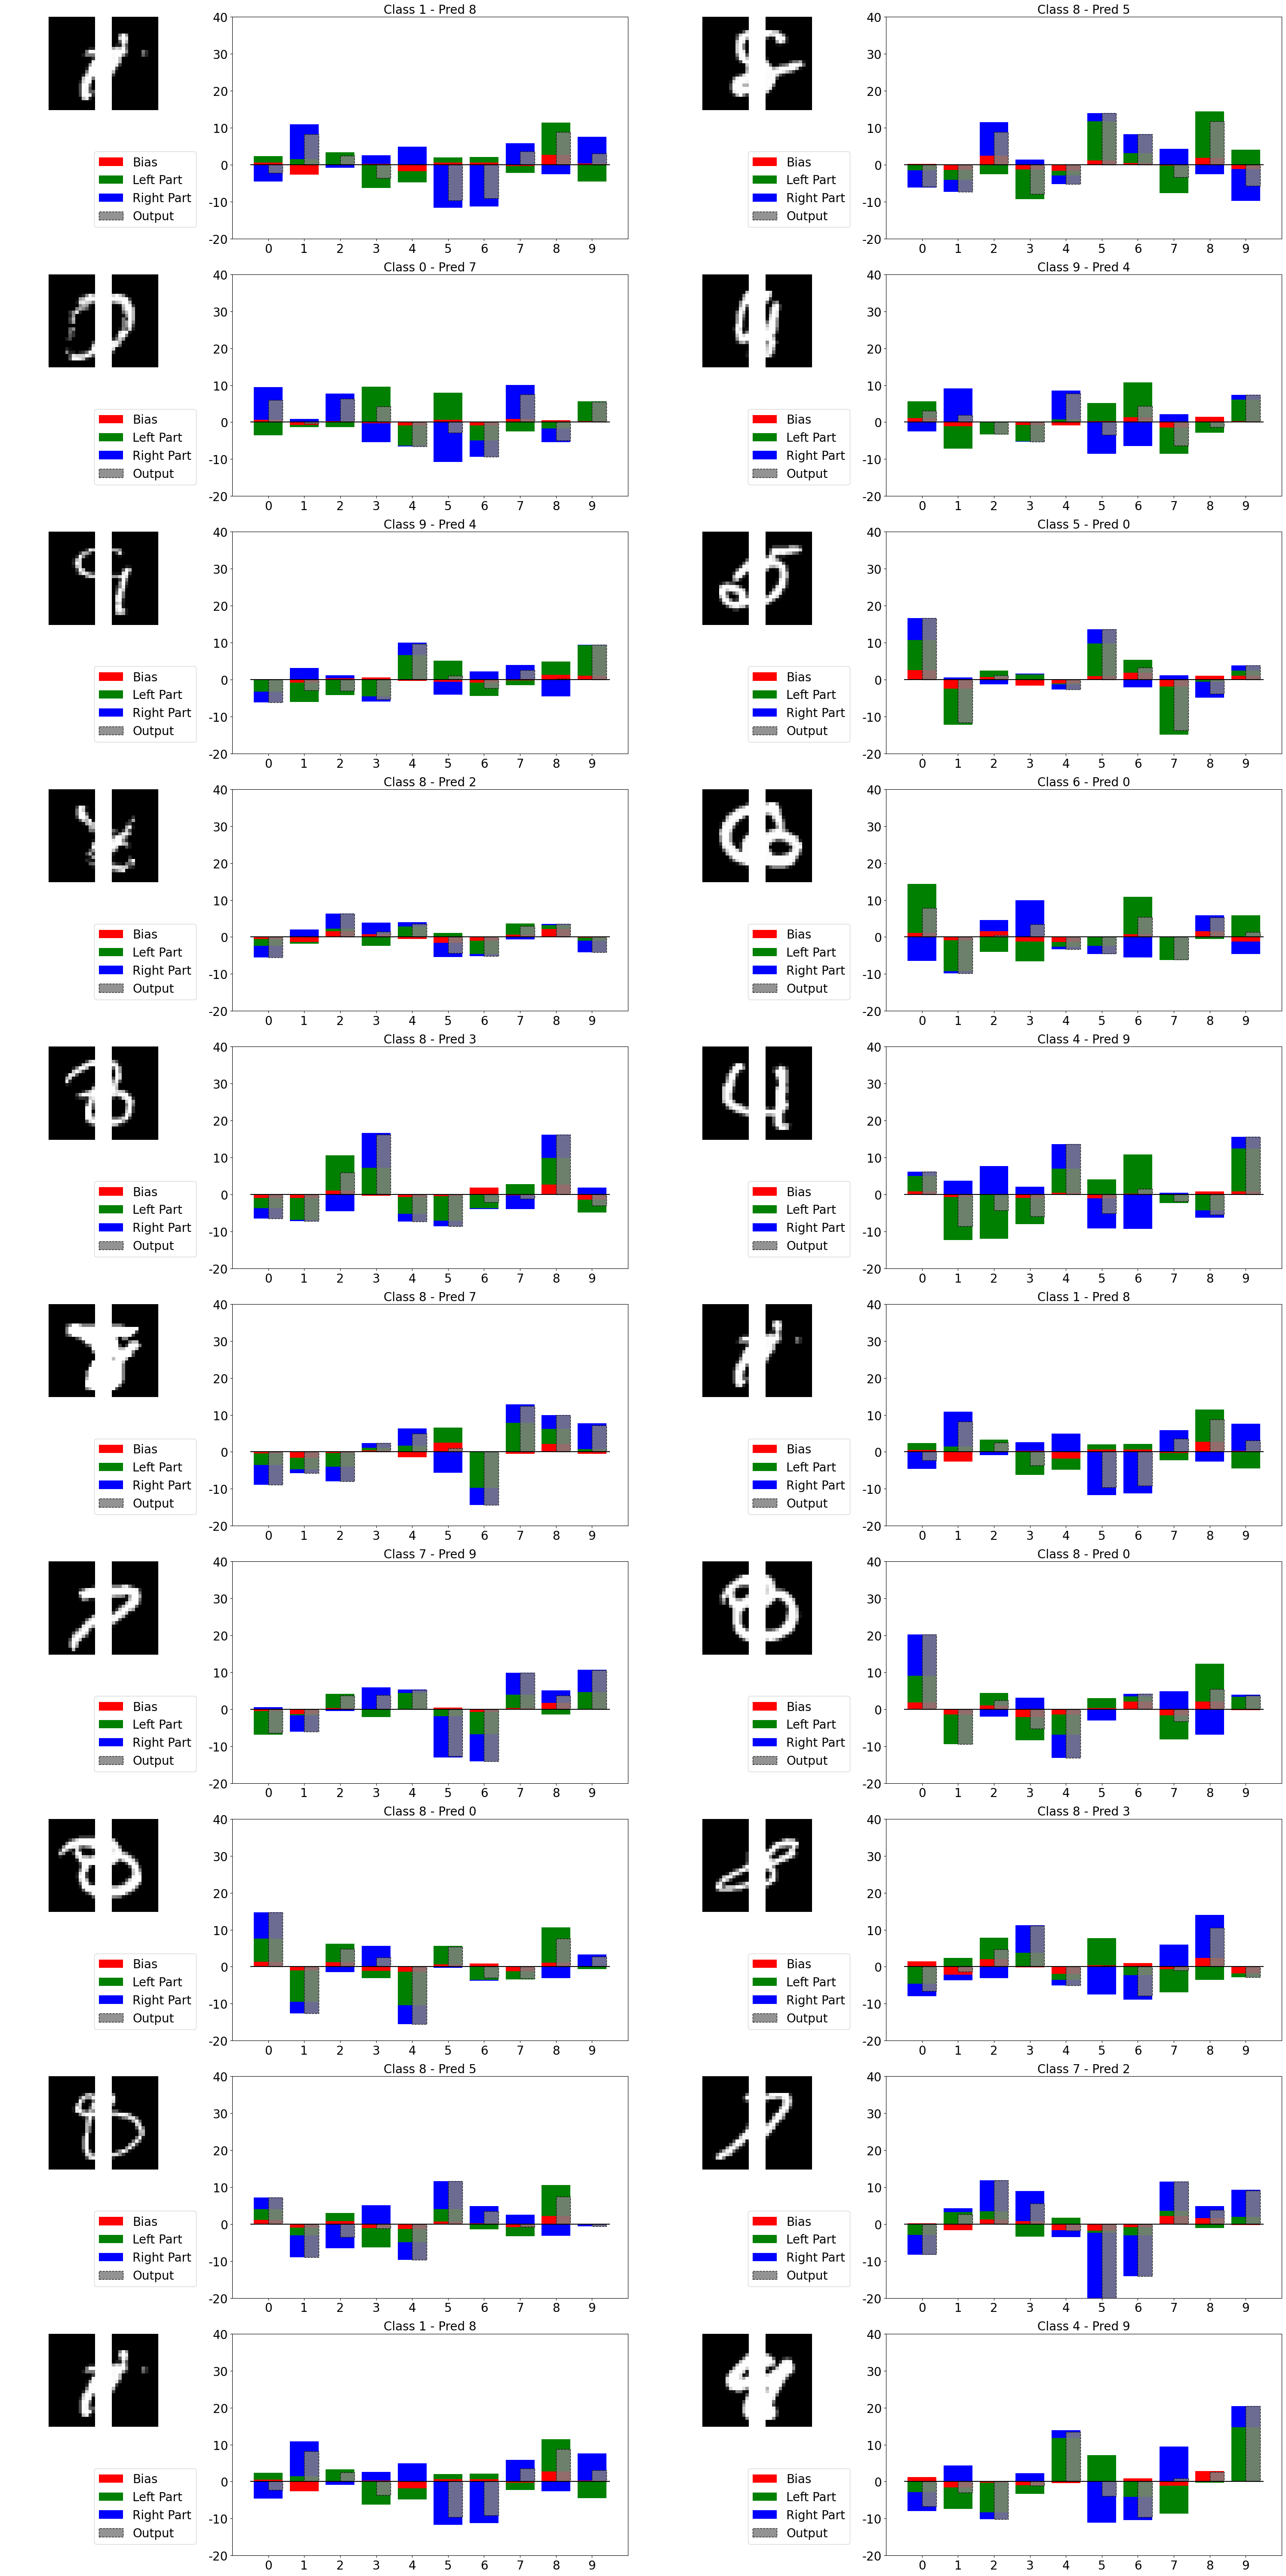

In [50]:
set_seed(42)
fig = plt.figure(figsize=(30,60))
fontsize = 20

gs = GridSpec(2*nrows, 2*ncols, 
              figure=fig, 
              height_ratios=nrows * [0.5,0.5], 
              width_ratios=ncols * [0.5, 1])

labels_str = ["Bias", "Left Part", "Right Part"]
preds = rfp_test_pred_list.sum(0).argmax(-1)
for i in range(nrows):

  sample_ids = [idx for idx in torch.randperm(len(test_data)) if test_data.orig_labels1[idx] != preds[idx]]
  
  for j in range(ncols):

    sub_sample_id = sample_ids[j]

    data1 = test_data[sub_sample_id]
    data2 = test_data[sub_sample_id]

    ax_tl = fig.add_subplot(gs[2*i, 2*j])
    ax_tr = fig.add_subplot(gs[2*i+1, 2*j])
    ax_b = fig.add_subplot(gs[2*i:2*i+2, 2*j+1])
    
    ax_tl.axis('off')
    ax_tl.matshow(torch.cat([data1["img1"][0], torch.ones([28,5]), data2["img2"][0]], 1), cmap="gray")

    plt.bar(range(10), rfp_test_pred_list[0,sample_ids[j]], label=labels_str[0], color='r')
    plt.bar(range(10), rfp_test_pred_list[1,sample_ids[j]].clip(min=0), bottom=rfp_test_pred_list[:1,sample_ids[j]].clip(min=0).sum(0), label=labels_str[1], color='g')
    plt.bar(range(10), rfp_test_pred_list[1,sample_ids[j]].clip(max=0), bottom=rfp_test_pred_list[:1,sample_ids[j]].clip(max=0).sum(0), color='g')

    ax_b.bar(range(10), rfp_test_pred_list[2,sample_ids[j]].clip(min=0), bottom=rfp_test_pred_list[:2,sample_ids[j]].clip(min=0).sum(0), label=labels_str[2], color='b')
    ax_b.bar(range(10), rfp_test_pred_list[2,sample_ids[j]].clip(max=0), bottom=rfp_test_pred_list[:2,sample_ids[j]].clip(max=0).sum(0), color='b')
    
    ax_b.bar(torch.arange(10)+0.2, rfp_test_pred_list[:3,sample_ids[j]].sum(0), label="Output", width=0.4, color='gray', alpha=0.85, linestyle="--", edgecolor="black")
    ax_b.hlines(y=0,xmin=-0.5, xmax=9.5, color="black")
    ax_b.set_ylim([-20,40])     
    ax_b.set_xticks(range(10))

    ax_b.set_xticks(range(10), range(10), fontsize=fontsize)
    ax_b.set_yticks(range(-20,41,10), range(-20,41,10), fontsize=fontsize)

    ax_b.set_title(f"Class {data1['label']} - Pred {rfp_test_pred_list[:3,sub_sample_id].sum(0).argmax(-1).item()}", fontsize=fontsize)
    ax_tr.axis('off')
    ax_tr.legend(*ax_b.get_legend_handles_labels(), fontsize=fontsize)

  fig.tight_layout()
